In [9]:
# import sys
# !{sys.executable} -m pip install 
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
raw_dataset = pd.read_csv("~/data/glac/T_models/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")

dataset = raw_dataset.copy()

#examine data columns
dataset.head()

/bin/bash: conda: command not found


ImportError: libpoppler.so.91: cannot open shared object file: No such file or directory

In [2]:
!python3 --version

Python 3.6.8


In [3]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [4]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [5]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

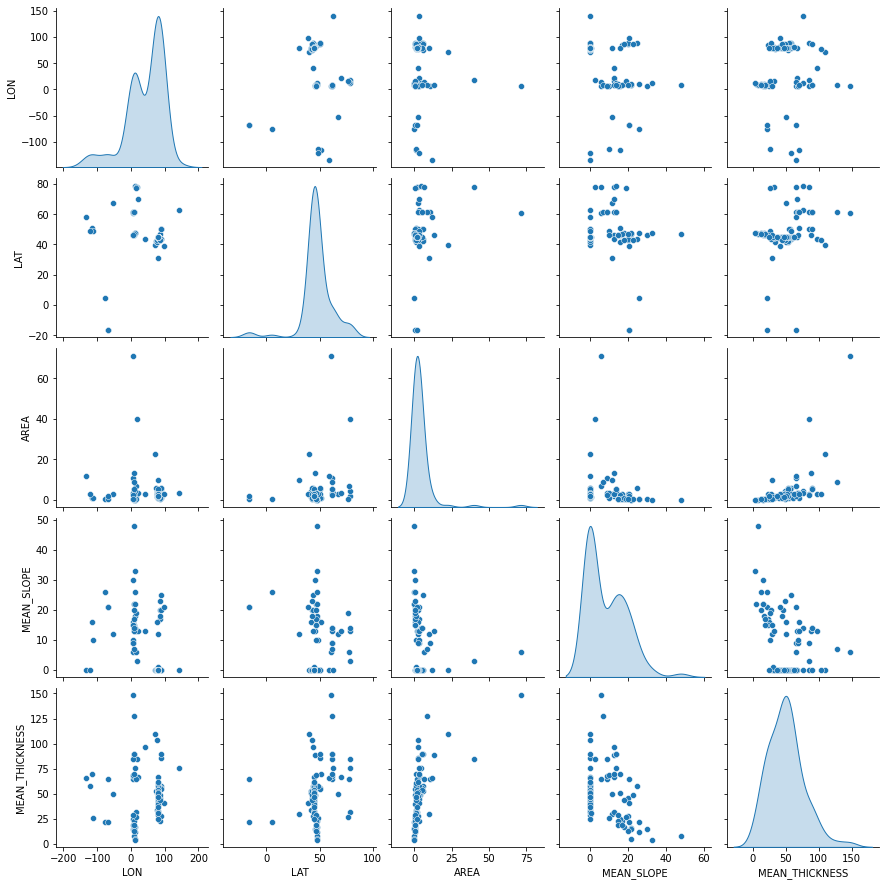

In [6]:
sns.pairplot(train_dataset[["LON","LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [7]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [8]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [9]:
normalizer = {}
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

2021-12-16 13:38:33.461369: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-16 13:38:33.461444: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2021-12-16 13:38:33.462599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Single variable linear regression functions

In [10]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [11]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [12]:
%%time
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

KeyboardInterrupt: 

KeyError: 'LON'

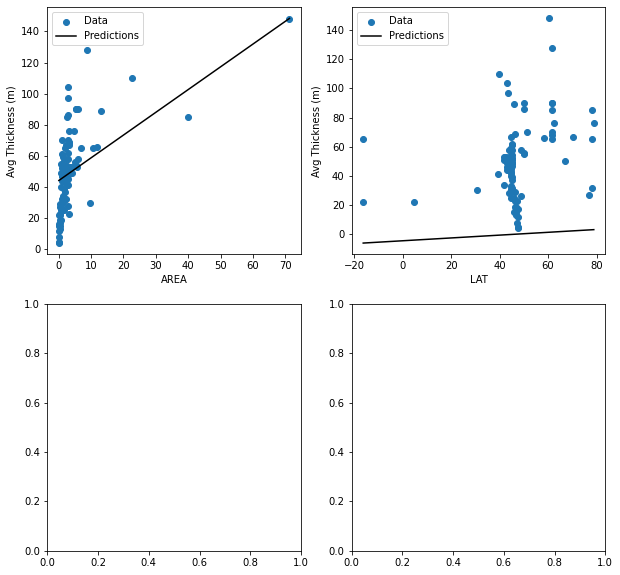

In [13]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = linear_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])

In [ ]:
# thiswillcrash()

# Linear regression with multiple inputs

In [ ]:
linear_model = build_linear_model(normalizer['ALL'])

history = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

In [ ]:
plot_loss(history)

# DNN regression

## Define regression functions

In [ ]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [ ]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [ ]:
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])

# Full model

In [ ]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [ ]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

In [ ]:
plot_loss(history_full)

In [ ]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,150),(0,150),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

In [ ]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')

In [ ]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results